In [1]:
import rclpy
from rclpy.node import Node

from std_msgs.msg import String
from sensor_msgs.msg import LaserScan

import numpy as np
import time

rclpy.init()

In [2]:
scan_buff = None

class LaserSubcriber(Node):
    def __init__(self, node_name='laser_scan_subcriber', capacity=100):
        super().__init__(node_name)
        
        self.subscription = self.create_subscription(
            LaserScan,
            'scan',
            self.listener_callback,
            10
        )
        
        self.msg = None
        self.buff = []
        self.capacity = capacity
    
    def listener_callback(self, msg):
        global scan_buff
        # self.get_logger().info(f"\rI heard a msg {type(msg)}")
        
        self.msg = msg
        
        if len(self.buff) >= self.capacity:
            self.buff.pop(0)
        
        self.buff.append(msg)
        scan_buff = self.buff
        

In [3]:
from threading import Thread

def run_laser_node():
    executor = rclpy.executors.SingleThreadedExecutor()

    laser_subcriber = LaserSubcriber(capacity=10)

    rclpy.spin(laser_subcriber, executor=executor)


t = Thread(target=run_laser_node)
t.start()

time.sleep(5)

In [4]:
import numpy as np

scan_msg = scan_buff[0]
np.array(scan_msg.ranges).shape, scan_msg.angle_min, scan_msg.angle_max, scan_msg.range_min, scan_msg.range_max


((360,), 0.0, 6.28000020980835, 0.11999999731779099, 3.5)

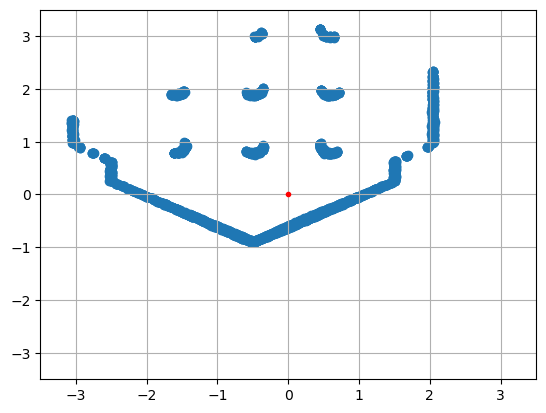

In [5]:
import matplotlib.pyplot as plt
from IPython import display


def plot_relative_map():
    x = []
    y = []

    for scan_msg in scan_buff.copy():
        current_data = np.array(scan_msg.ranges).copy()
        angles = np.linspace(scan_msg.angle_min, scan_msg.angle_max, len(scan_msg.ranges))
        for angle, dist in zip(angles, current_data):
            x.append(-1*dist*np.sin(angle))
            y.append(dist*np.cos(angle))
        
        display.clear_output(wait=True)
        
        plt.clf()
        plt.xlim(-scan_msg.range_max, scan_msg.range_max)
        plt.ylim(-scan_msg.range_max, scan_msg.range_max)
        plt.plot(0, 0, '.r')
        plt.scatter(x, y)
        plt.grid()
        plt.pause(.1)

    plt.show()
    
plot_relative_map()

# Plot the map while robot is running

In the terminal, use teleop command to set robot:
- Linear velocity: 0
- Angular velocity: 0.4



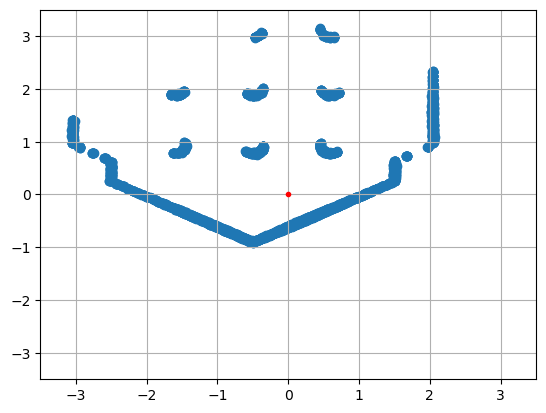

In [6]:
plot_relative_map()

# Odometry

In [7]:
from nav_msgs.msg import Odometry

odom_buff = None

class OdomSubcriber(Node):
    def __init__(self, node_name='odom_subcriber', capacity=100):
        super().__init__(node_name)
        
        self.subscription = self.create_subscription(
            Odometry,
            'odom',
            self.listener_callback,
            10
        )
        
        self.msg = None
        self.buff = []
        self.capacity = capacity
    
    def listener_callback(self, msg):
        global odom_buff
        # self.get_logger().info(f"\rI heard a msg {type(msg)}")
        
        self.msg = msg
        
        if len(self.buff) >= self.capacity:
            self.buff.pop(0)
        
        self.buff.append(msg)
        odom_buff = self.buff

In [8]:

import rclpy.executors


def run_odom_node():
    executor = rclpy.executors.SingleThreadedExecutor()    
    odom_node = OdomSubcriber()

    rclpy.spin(odom_node, executor=executor)


o = Thread(target=run_odom_node)
o.start()

time.sleep(5)

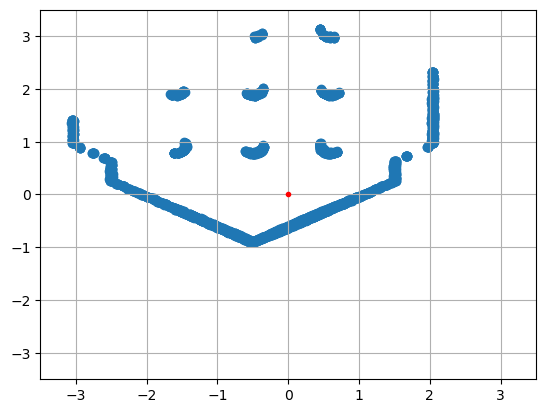

In [9]:
x = []
y = []

for scan_msg, odom_msg in zip(scan_buff.copy(), odom_buff.copy()):
    current_data = np.array(scan_msg.ranges).copy()
    angles = np.linspace(scan_msg.angle_min, scan_msg.angle_max, len(scan_msg.ranges))
    for angle, dist in zip(angles, current_data):
        x.append(-1*dist*np.sin(angle))
        y.append(dist*np.cos(angle))
    
    display.clear_output(wait=True)
    
    plt.clf()
    plt.xlim(-scan_msg.range_max, scan_msg.range_max)
    plt.ylim(-scan_msg.range_max, scan_msg.range_max)
    plt.plot(0, 0, '.r')
    plt.scatter(x, y)
    plt.grid()
    plt.pause(.1)

plt.show()

In [11]:
odom_msg.pose.pose.position.x
odom_msg.pose.pose.position.y
from transformations import euler_from_quaternion

rotation = euler_from_quaternion((
    odom_msg.pose.pose.orientation.x,
    odom_msg.pose.pose.orientation.y,
    odom_msg.pose.pose.orientation.z,
    odom_msg.pose.pose.orientation.w,
    ))[0]

rotation

9.76380707771224e-07